### 1. 异常模型

#### 1.1 参数异常模型

回顾一下web威胁中的几大类攻击，SQLI，XSS，RCE...等虽然攻击方式各不相同，但基本都有一个通用的模式，即通过对参数进行诸如payload来进行攻击，参数可能是出现在GET、POST、COOKIE、PATH等位置。所以第一个异常模型，我们希望能覆盖掉参数中出现的异常，这样就能覆盖掉很大一部分常见的web攻击。

#### 1.1.1 模型原理

假设有这样一条URL：www.xxx.com/index.php?id=123。如果我们拉出所有这条URL的访问记录，不难发现：正常用户的正常请求虽然不一定相同，但总是彼此相似；攻击者的异常请求总是彼此各有不同，同时又明显不同于正常请求。

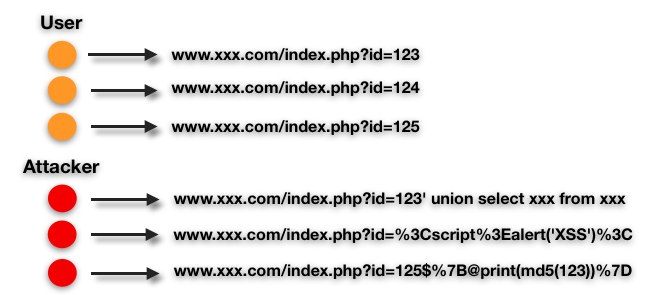

正常总是基本相似，异常却各有各的异常。基于这样一条观测经验，如果我们能够搜集大量参数id的正常的参数值，建立起一个能表达所有正常值的正常模型，那么一切不满足该正常模型的参数值，即为异常。

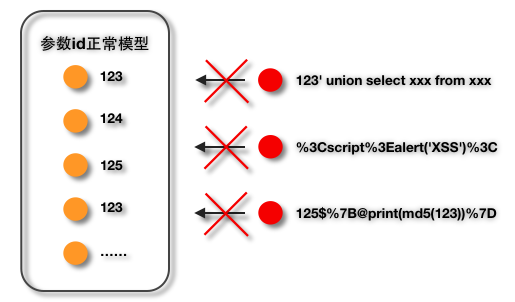

如果我们把参数id的每个参数值看做一个序列，那么参数值中的每个字符就是这个序列中的一个状态。同时，对于一个序列，为123或124甚至是345，其背后所表达的安全上的解释都是「数字 数字 数字」，我们用「N」来表示「数字」，这样就得到了对应的隐含序列。

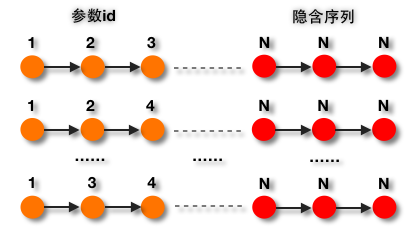

到这里已经隐约看到了隐马尔可夫的影子。对于数字我们用N来表示，响应的对于其它unicode字符，也做类似的泛化对应关系。英文字符、中文字符、中文标点字符以及其它语言的所有字符对应状态「A」，对控制字符以及英文标点字符，对应隐含状态为自身。

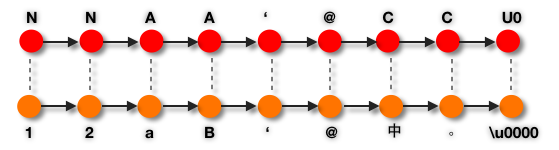

这样做的原因是因为通常一个参数注入式的web攻击payload是由一些攻击关键词，加上一些特殊符号构成。特殊符号起到闭合前后正常语句，分割攻击关键词的作用。通常这些特殊字符为英文标点字符、控制字符等，所以对这些字符不做泛化的对应。

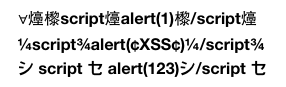

但是，也有一些特殊情况，如上几个XSS payload是利用了字符集编码转换：故也可以考虑对「㸀㰀シセ¼¾……」等几个特殊字符单做处理。

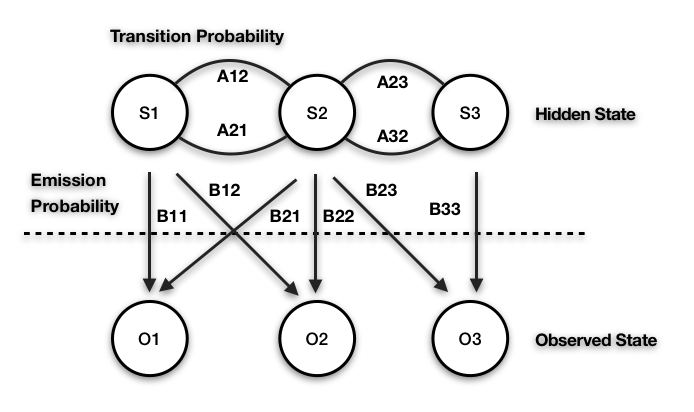

回顾一些HMM的三类应用：

解码问题，根据模型参数和观测序列，找出该观测序列最优的隐含状态序列；评估问题，根据模型参数和观测序列，计算该观测序列是由该模型生成的概率；学习问题，根据一系列观测序列，建立对应序列最优的HMM模型。

这里我们只用到后两个。在训练阶段，对应「学习问题」，用大量正常的参数值训练出站点www.xxx.com下index.php下的参数id的HMM模型；在检测阶段，对应「评估问题」，待检测的参数值带入模型检测是否正常。

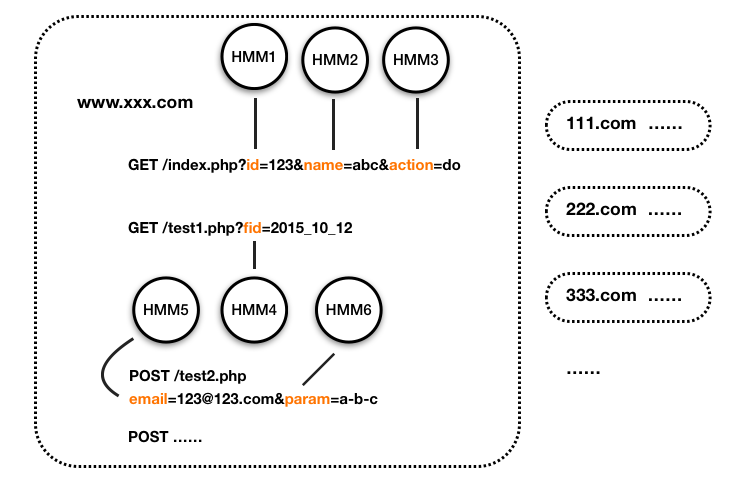

不同的参数，正常的值不同。同时，有参数传递的地方，就有可能发生参数注入型攻击。所以，需要对战下所有路径下的，所有GET、POST、PATH、COOKIE中的所有参数都训练各自的正常模型。另外，对参数名本身，也训练其正常的模型，见如下case：

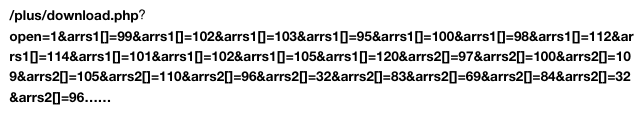

> 思考：以上这种方法使用HMM建模的方法过于繁琐，需要针对不同的参数建立多个HMM模型，但是相对来说判断应该比较精准，比较细。我的想法是，建立一个HMM，隐状态就两种，恶意URL和良性URL，观测数据为参数的个数，每个观测数据中对应的参数划分我们使用NLP对文本的hash编码方式得到每个参数的01100类似这样的构造，这种方法表示可以根据需要达到的精度和计算量间进行调整，如果需要精细化判断，就按照参数进行精细化划分，再将得到的这个编码后的参数转化为十进制，就得到字符到数值形式的转换，以这种方式得到每个URL对应的观测数据，再使用隐马尔可夫中的三大问题中的学习得到最优参数模型，使用评估对新的URL进行判断。判断的依据就是根据正常模型得到的概率与新的URL得到的概率进行对比。这是对URL中的参数，其它地方，如HTTP header中，COOKIE中都需要如此建模。如果这种基于HMM的方法可以成立，因其字符对应方法就有点类似使用正则表达，我觉得这里使用正则化更加简单，计算量也更小。

#### 1.1.2 工程实现

整个模型包含4个主要模块，抽取器「Extractor」、训练器「Trainer」、检测器「Detector」、重训练器「reTrainer」。

对每条HTTP原始日志，先经过Extractor进行参数拆解，各种ETL（抽取、加载、转换），解码等处理。这一步是最容易描述但确是最难做好的。比如URL中虽然都是百分号编码，但字符集却有GBK、UTF-8、GB2312等等，如何选择正确的字符集来解码？比如POST传递参数，可以通过urlencoded、multipart/form-data、json或xml等，如何保证能够正确的提取？

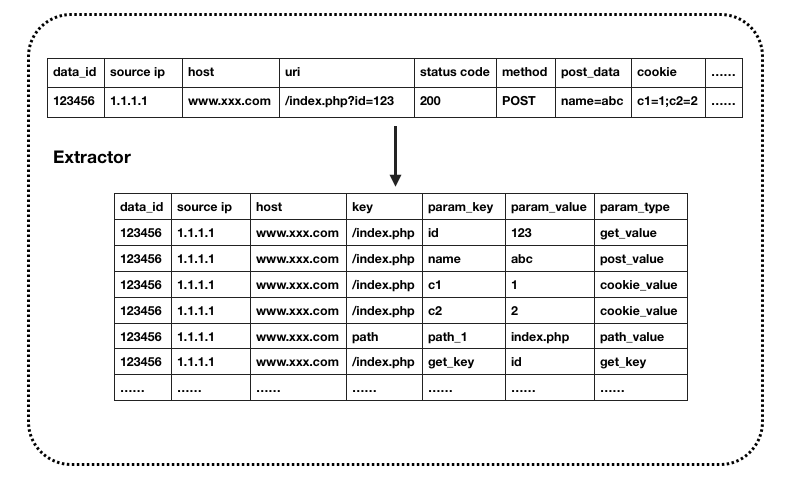

良好的数据质量，才能保证上层建筑的精准。有句话是这么说的「宁愿去洗厕所，也不宁愿洗数据」，但是不经历负数据之脏，如何有资格经历数据之美？「Extractor」出来的数据，根据是否已经有对应的训练好的模型，拆分为部分，没有对应模型的数据进入Trainer开始训练流程。

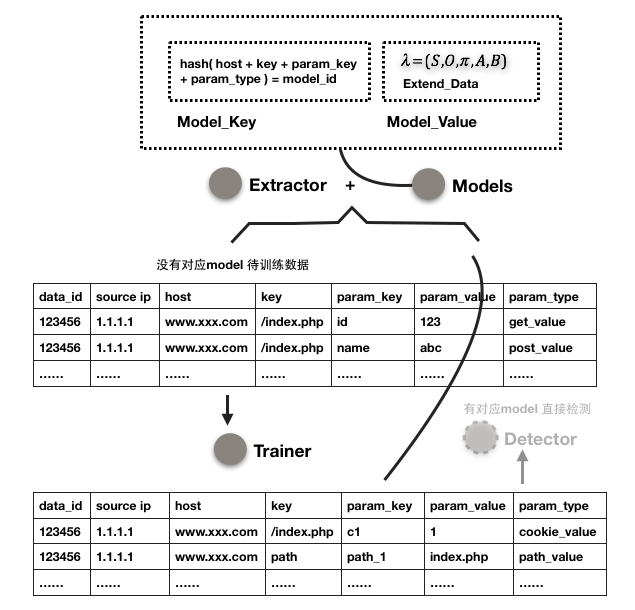

> 说明：这个可以对每个IPhash后得到的data_id来分别训练对应的模型。

上文中我们提高，我们要训练的是正常参数值从而得到正常模型。这就需要保证进入训练集中的数据都必须是正常数据。如果都是一场数据，那么得到的关于异常的模型，也就是说模型会被污染。那么问题来了，如何在不知道什么是正常的情况下保证正常？

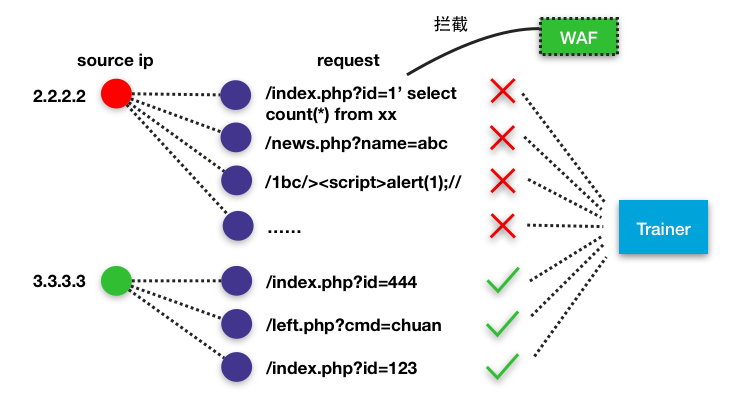

第一步，对某个IP，只要其当前内所有请求中有一条命中了WAF，其余所有请求不管是正常的还是异常的，均不进入Trainer；如果某个IP命中扫描枪特征或扫描器行为，该IP所有请求也不进入Trainer。

> 说明：此步骤为筛选正常模型的标准，即为正常的是没有一点污点的数据。

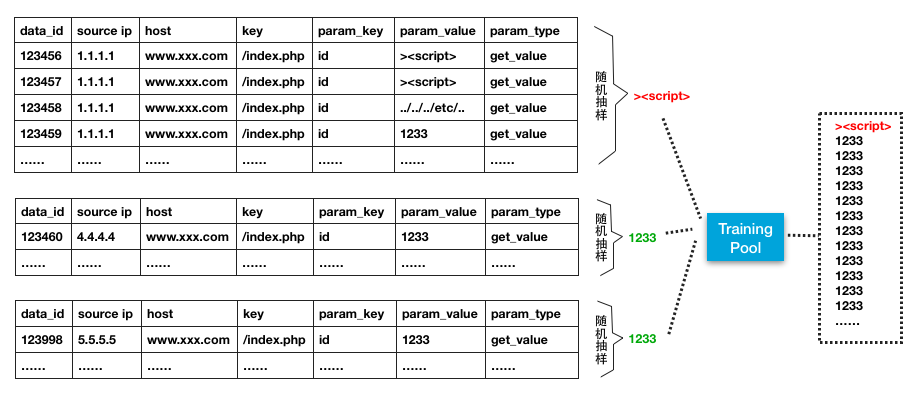

第二步，对每个要训练的参数，每个IP每天只能贡献一次参数值（意思是说每个正常IP的模型训练只选择具有相同参数中的一条数据进入Trainer，避免有多个是异常数据进入，这样会造成负例过多，进而影响模型）。这样能保证上述过滤失效的情况下也只能有一条异常数据混进该参数的Trainer中。只要大多数进入训练池的数据是正常的，那么对模型的影响也不大。这就是「正常由大多数投票表决来决定」。同时，每个参数的训练池有最低条数的限制，每达到条数限制的参数不做训练，继续等待更多的数据进入Trainer（这主要是保证所有正常模型的质量，通过多条不同参数的正常数据来判断。）

有最低限制，就响应的有最高限制，对于部分数据量很大的参数，过多的训练数据会导致训练时间太长。对这种情况，我们再做一个分层抽样。

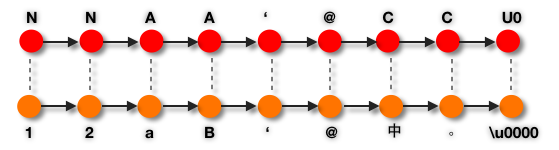

在模型原理部分我们提高观测序列与隐含序列的对应关系，但在工程实现中这样去做，会存在很大的问题。比如训练集中id参数的观测序列全为「123abc」，相应的隐含序列为「NNNAAA」，训练好模型后，待检测序列为「124abc」。由于「4」这个观测状态不再训练集的状态空间中，所以会被直接判定为异常。

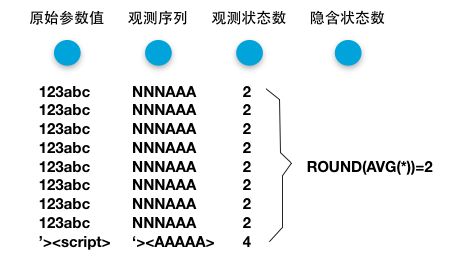

但事实上我们并不需要这么「敏感」的异常。所以我们直接使用泛化后的序列「NNNAAA」作为观测序列，而隐含状态数取训练集中所有观测序列的观测状态数均值四舍五入。

模型完成训练后，需要设定一个异常的阈值。什么样的概率值的序列为异常？0.8，0.5？如果训练集中所有参数值均为正常，那么只需取集中的最低概率值为阈值即可。但即便之前我们做了这么多步，也是有可能混入一两条异常数据进入训练集的。这里我们可以简单的使用3sigma来抵消，如果最低概率值位于3sigma区间外，取次低概率值，再求3sigma，如此反复。

> 说明：3sigma原则是说假设得到的正常数据和异常数据都符合正太分布的，就有在$\mu\pm3\sigma$之间的数据被认为是正常数据，而非异常数据，换句话说我们用这种方法来检测这个最低概率是不是异常数据，或者说我们可以换个思路，直接求针对每个IP得到的所有模型的概率，假设是符合正太分布的，就可以使用这种方法去掉所有可能的异常值之后取最低的那个概率作为阈值。

「Trainer」部分结束后，开始「Detector」部分。从「Extractor」出来的有对应Model的数据，直接开始检测，如果概率P小于异常概率阈值H - epsilon销量，则认为是异常，epsilon=(1/100)H。异常的数据最终再由data_id还原出对应的原始HTTP数据。

任何模型都有衰减期，尤其是攻防模型。昨天的遗产长不一定今天就是异常，这就需要有一个重训练模型「reTrainer」来持续迭代训练模型，用以抵消衰减的影响。比如/index.php?id=123在训练时id为123是正常的，但之后该web应用修改了代码，正常的参数变成了/index.php?id=abc+||+123，如果模型一层不变，所有之后的abc++123都会被认为是异常。

> 思考：针对以上情况，我们可以再泛化对应时，控制这些特殊符号的关系，使得对应关系需要那么死！

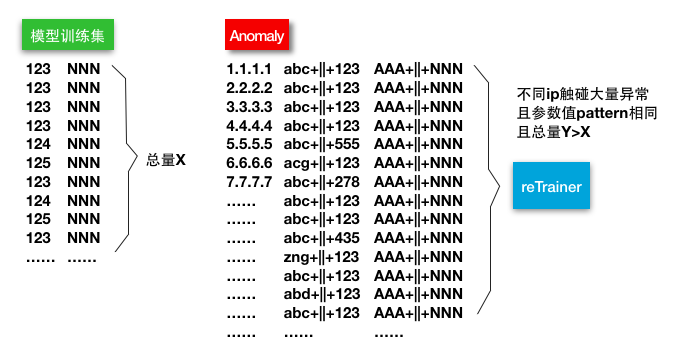

那么什么时候需要开始重训练呢？当过去的「大多数」已经不能代表现在的「大多数」的时候。若大量不同人对某个参数出现大量相同序列的异常，且这些异常都不会命中威胁模型。同时，数量上远大于对应的模型的训练集中的数据量，训练集中的参数值序列也持续一段时间没有再出现过，则将这部分异常开始重训练。则将这部分异常开始重训练。至此，整个参数异常模型部分结束。

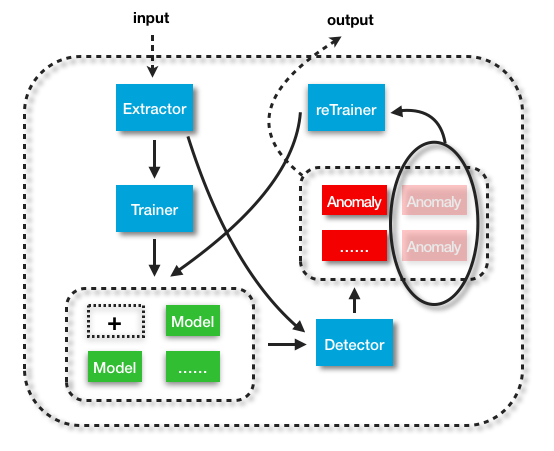

> 说明：上述的意思是针对建模之后出现的新数据样本的检测，当之前用于训练的观测序列不再在新样本数据有效时，或者说这个模型对于新的样本几乎都不能检测时，就该重新训练了。

#### 1.2 节点异常模型

不能寄希望于一个模型就能覆盖掉所有攻防上的异常，比如webshell、敏感文件下载等这些web威胁，在参数异常模型中，不会触发任何异常。所以考虑从另一个角度，来覆盖这类节点异常。

#### 1.2.1 模型原理

如果把站点看做一张大图，站点下的每个页面为这张大图中的每个节点，而不同页面之间的链接指向关系为节点与节点之间的有向边，那么我们就画出如下这张有向图：

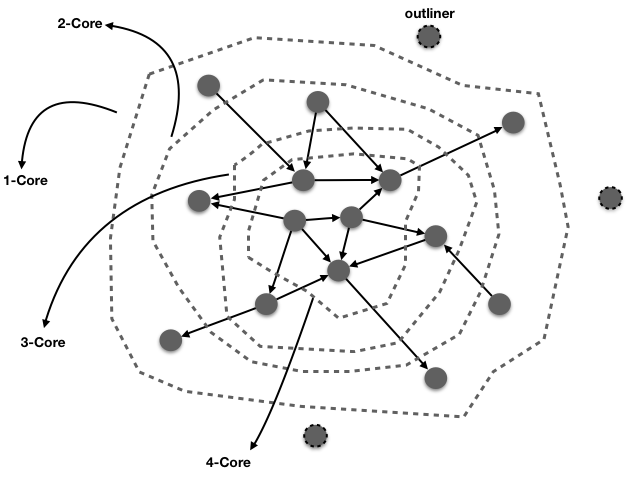

节点是否异常，由其所处的环境中的其它节点来决定。类似一个简化版的PageRank，如果大量其它节点指向某个节点（入度较大），那么该节点是异常的概率就很小。相反，如果一个节点是Graph中孤立点（入度为0），则是异常的概率就很大。（这个节点一般来说是不属于该站点，比如在僵尸网络中被人植入了webshell，这个webshell一般是存放在其它网站的）

单有这张有向图还不够，诸如/robots.txt、/crossdomain.xml之类的正常节点却又无其它节点指向的情况太多了，这个层面的异常能表达的信息量太少，所以我们还需要引入另一个异常。（<font color='red'>这类节点是指定哪些可以访问，哪些不能访问的节点，也满足入度小但是确实正常节点</font>）

通常一个异常节点（如webshell），大多数正常人是不会去访问的，只有少量的攻击者会去访问（<font color='red'>这里不考虑修改页面写入webshell的情况，这个模型不能覆盖这类case，意思是直接在本网站放入这个webshell，而不是将其放到别处</font>）。用一个简单的两步有向图就能很好地表达。入度越少的节点，同样越有可能是异常。

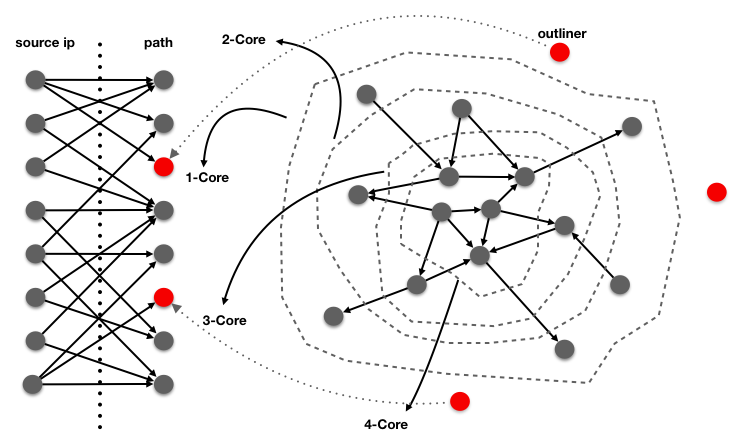

联合两张图中的异常，其联合异常就会比单独任意一张图产出的异常更具表达力。该模型较为简单，不再赘述。

#### 1.2.2 工程实现（永远是简单易用，计算量低，效率高，扩展性灵活性强的模型）

整个模型包含3个主要模型，抽取器「Extractor」、训练器「Trainer」、检测器「Detector」。对每条HTTP原始日志，同样先经过「Extractor」进行路径抽取，各种ELT，解码等处理。这里需要由于有向图中的边关系由referer->path来决定，而referer是可以轻易伪造的，所以，需要对fake referer做个检测。

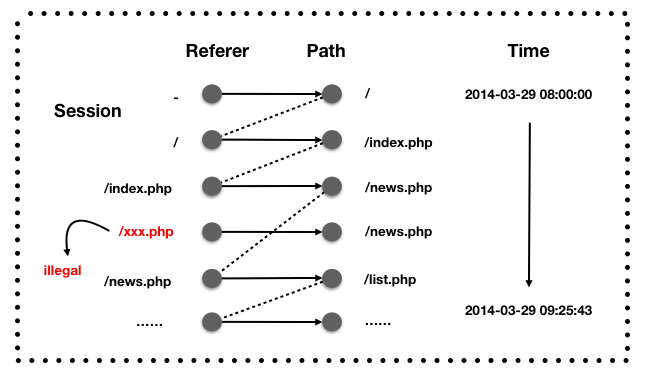

先做一个session identification，对每个session块中的数据，分析其导航模式。正常的referer必然会出现在当前session中之前的path数据中。同时，能够与当前session之前的数据形成连通路径。（也就是正常的referrer必定是在当前session中之前访问的path，并且能够形成referrer与path的连接通路）当然，导航模式并不能完全检测所有的伪造referer，攻击者完全可以先访问A，再构造一个referer为A访问B的请求。不过没关系，后面还有方法能避免这些数据进入Trainer。（<font color='red'>这个过程可能会混入某些伪造的数据</font>）

「Extractor」出来后的数据，直接进入「Detector」，Detector检测path是否再有向图中，如果在，则更新有向图中节点的最后访问时间；如果不在则认为是有向图异常，进入到二步图中。二步图维护一个N天的生命周期，如果某path节点总的入度小于L，则为最终异常（<font color='red'>如果这个访问的path不在有向图中，也就是它很有可能是外部植入的一个网站节点，且一般一段时间内访问的次数要远小于其它正常节点的</font>）

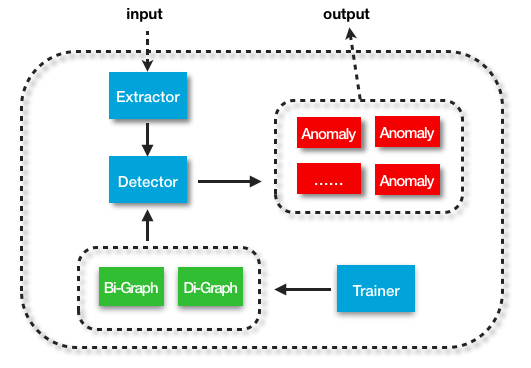

### 2. 威胁模型

#### 2.1 攻击识别

99%的异常实际上都不是什么攻击，异常的发现并不难，难的是对异常的解读，或者说赋予异常一个安全业务上的解释，理论上来说，如果能有足够丰富的各个层面的数据，能够对每个异常都作出一个合理的解释。

上文中我们提到，多数的普通web攻击都是由「特殊字符」加上「攻击关键词」这种模式构成。而参数异常模型本省就能够很好地表达「特殊字符」，剩下的我们其实只要能表达「攻击关键词」这一层的信息即可。

所以我们想尝试在参数异常数据的基础上，诸如一些领域知识，从而构成一个分类器，从异常中剥离出攻击，并且能够对不同种类的攻击进行分类。但我们又不太想认为构造样本人工打标签，因为这样又会带来一些个体因素的影响，我们希望能用真实世界中的流量来获得领域知识。

首先第一步，我们先从WAF中提取近几年的数据，对各个类别的攻击payload做一个简单的分词。然后再从参数异常模型的历史数据中提取大量的「绝对正常」样本，也做一个简单的分词。显而易见，如果某一词在一类攻击payload样本中出现的次数越多，那么我们认为该词与该来攻击的相关程度越大。同时，不同的词的重要程度是不同的，如果该词只在这类攻击中出现，而在正常样本中几乎没有出现，那么该词对该类攻击重要性更高。

> 说明：这边采用NLP中TFIDF的方式，得到某词的重要程度，TFIFT值越大，说明该词的重要度就高，换句话说该词与该类攻击相关性也就越大。

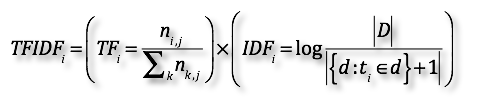

自然就联想到了TF-IDF。数学意义上，TF用来表达相关程度，IDF用来表达重要程度。在TF中，分子部分，表示i这个term在攻击类别中出现的次数。为了避免对「短payload攻击」的不利，需要将词数（term count）转换为词频（term frequency），所以分母部分表示在攻击类别j中所有term出现的总次数。在IDF中，分子部分表示所有样本库中（包含正常和攻击）的样本总数，分母部分表示包含term的样本数，加1是为了避免为0，取对数是为了表达term的信息量。最终TF与IDF二者相乘，用来刻画一个term对该类攻击的描述程度。（在term如果在攻击中频繁出现，但是却也在正常样本中也出现，那说明该词并不那么重要，而如果说在正常样本中几乎不出现，那说明该词与该攻击相关度较高）

接下来就涉及到分类器的选择，事实上我们在测试了多个分类器后，发现在场景下，仅仅就用简单的基于规则的分类器就已经满足大部分的情况。如果还想继续提高精度，可以尝试再表达term与term之间的顺序关系，如二元gram，长亭科技提到的基于编译原理的语法分析等等。另外一种思路是直接描述整个payload的「结构」特征。例如如下两个payload，如果采用类似参数异常模型中对序列泛化的思路（长度上也做压缩泛化），将得到一条相同的泛化序列：

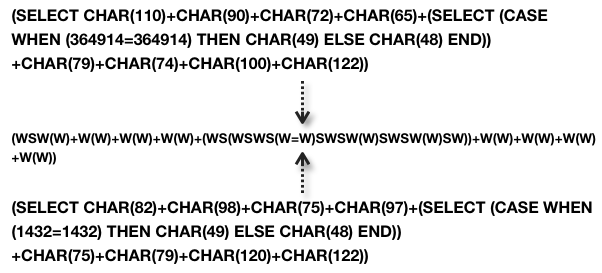

不难发现，其结构上是相同的。事实上我们抽取了WAF 1000W+真实环境中的SQLI payload分析后发现，其泛化后的序列只有几万。所以从「结构」这条路上取探索，也是个不错的选择。

#### 2.2 识别成功的攻击

在异常中，99%的异常都不是攻击，而在攻击中，99%的攻击又都是无害的攻击。而我们的精力总是有限的，我们希望能关注那些危害程度更高的攻击，这就迫使我们需要从攻击中识别出哪些是成功的攻击。

Kill Chain的思想本身是很好的，在攻击者的攻击链路上的几个关键节点，如果能串联起来，说明这是一次成功的攻击，但是Kill Chain涉及最初是为了检测APT，所以在web威胁中，我们只需要借鉴种种思路，而每必要生搬硬套7个阶段。

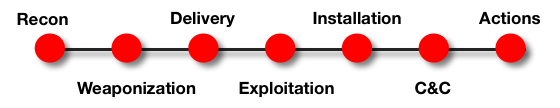

Kill Chain的本质还是多源异构数据的关联，攻击路径上不同层面的数据来建立联系。我们可以采用很简单的二步验证，如一个HTTP层出现的SQLi payload，相同的payload同时出现在SQL层的异常，即形成一个确认的SQLi攻击；同理，一个HTTP层的异常相同的payload出现在了命令日志层面的异常中，即形成一个确认的RCE。

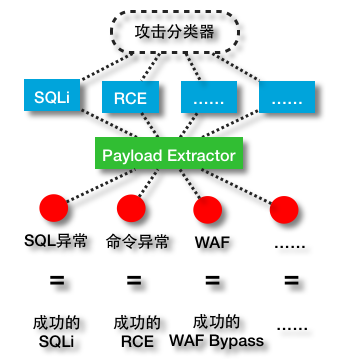

相同的思路，我们也可以同安全产品的数据来关联。如，关联WAF数据，关联不上的即为WAF Bypass；成功的攻击数据同扫描器数据来关联，关联不上的即为扫描器漏报等等。

> 说明：以上实现的目的是先识别出异常，然后从异常中识别出攻击，再从攻击中识别出有害的攻击，如果这种有害的攻击被识别，即如果WAF、扫描器等安全工具没有识别，即视为漏报或WAF Bypass。

#### 2.3 CMS Nday识别

涉及到HTTP这一层的数据，想必大家最感兴趣的，就是如何挖掘出一些web cms Nday。值得一提的是，如果只是挖出一些「可能」是Nday的请求，意义并不是很大，在大规模的环境中这样的请求每天实在是太多了，多到让人力不从心。抽象这个过程，我们希望能够做到两点：1. 明确知道这是一个Nday；2.明确知道这是哪个CMS的Nday。

Nday首先一定是一个攻击，所以不需要再从宜昌数据开始，攻击分类器中出来的数据可以直接作为源数据。但单过来攻击却不一定是Nday，通常情况下，大多数Nday是带Exp性质而非PoC性质的(PoC还是在探测阶段，而Exp直接是探测后的利用，一般是说明弱点必然存在)。比如SQLi的CMS Nday多数是直接读管理员表数据之类的「利用」行为，而非是「and 1=1」之类的「证明」行为。

而对于第二点，「知道这是哪个CMS」背后对应的其实是一个web应用指纹识别的过程，不过比传统的应用指纹识别更具挑战的是，因为无法知道哪个页面会出现Nday，所以只能通过一个HTTP数据，就要识别出对应的CMS。

另外，如果站在攻击者角度来考虑的话，Nday通常不会只出现在一个站点上。这一点很重要，能帮助我们过来掉很多噪声数据的同时，也能让我们感知某个Nday是否再大规模利用。

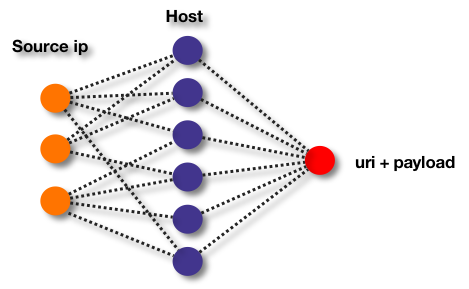

我们先从SQLi Nday尝试入手，观察如下这条payload：

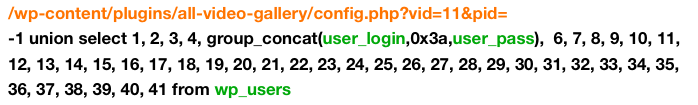

多数的SQLi Nday，都会有一个「from xxx」的pattern，而xxx为具有某个**CMS数据库的表名**，同时payload中也会出现**CMS数据库的字段名**。豁然开朗，我们需要做的，其实只是建立一个CMS DB Schema指纹库，以**CMS表名和字段名作为指纹**。一举两得，技能判定出是Nday，又能同时找到对应的CMS。

下面再来看看GetShell的Nday。多数的GetShell Nday，都会有「<? eval」「<? fputs」之类的webshell代码特征，或者是文件包含特征等等。同时，我们可以取**路径以及参数名作为URI指纹用来识别CMS**。

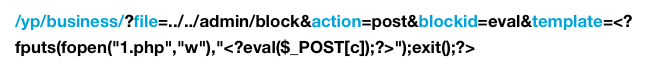

> 以上目的是用于确定时Nday攻击，并识别CMS的类别。

DB指纹很容易建立，相比之下URI指纹就不那么容易建立了，我们需要借力于WEB指纹识别产品。从**指纹识别产品**中提取CMS为wordpress的站点top 10000个，然后提取这1w个站点7天内的所有200的请求。取参数后，分别对**每个URI提取路径指纹和参数值指纹**。只有多个wordpress站点都同时具有该指纹，并且其他CMS没有该指纹的，才最终进入wordpress的URI指纹库。同理，其他CMS的建立过程也类似。

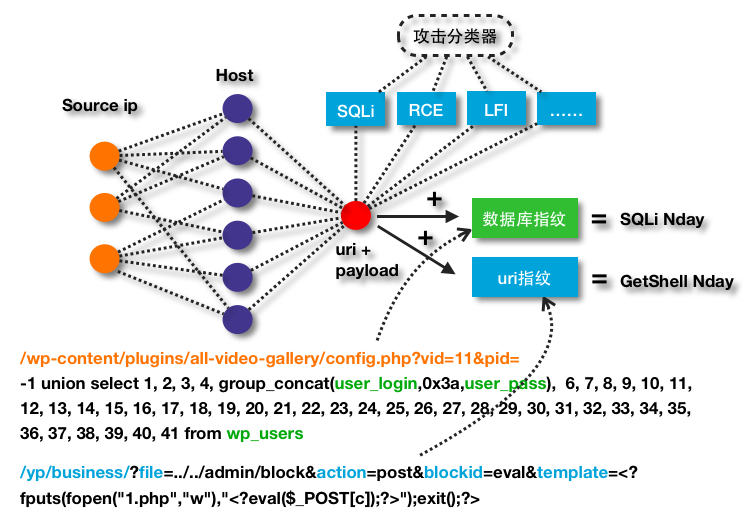

整个识别流程如上图所示，先取出攻击分类器中出来的攻击数据，兵器这些URI+payload出现在了多个站点上（确定其是Nday）。紧接着，满足SQLi pattern的数据同DB指纹库匹配，得到SQLi Nday；满足GetShell pattern的数据同URI指纹库匹配，得到GetShell Nday。

#### 2.4 weshell识别

以上几个场景都是基于参数异常的数据的应用，而对于节点异常数据，最为直接的应用就是识别webshell。先来回想一下，安全工程师在做入侵复盘时怎么来确认一个URL是否为webshell：1. 从HTTP数据中发现一个URL有点「异常」；2. 访问一下URI，通过安全经验知识从返回页面识别出是webshell（大马）；如果返回页面为空白（疑似一句话），从代码层面来识别。

#### 2.4.1 大马识别

先来看一下大马的识别。对于第一点节点异常数据已有，而第二点，本质上其实是引入response层面信息做网页相似度计算。对于相似度计算，不妨先将问题退化为「网页相同计算」。

问题变得非常好解。搜索大量的webshell样本，训练阶段对response数据计算MD5，检测时对待检测样本同样算md5比对即可。显而易见，**这种方法准确率极高，同样缺陷也足够明显，严重依赖训练样本库，也就是只能检测已知，不能感知未知**。

而人总是贪婪的，一方面我们即想对已知保持高的检测精度，同时又希望能保持一些对未知的感知能力。自然而然就想到了simhash之类LSH。类似md5，sha1之类的属于加密型HASH，其设计的目的就是为让整个分布金坑你第均匀。所以对输入极其敏感，轻微变化的输入，就会导致输出大不一样。而我们更希望对相似的输入，产生相似的输出。从而通过对输出做相似计算，就能反映出输出的相似性。然而事实上simhash在这个场景下效果并不是很好，**原因是主要适用于文本内容的相似性检测。**

抛开全文hash的想法，有一类方法是去关注全文汇总的片段。直观经验告诉我们，如果两个全文比较相似，那么全文中的部分全片，也很有可能很相似。反过来我们如果能计算出片段的相似或相同，进而就能得到全文的相似性。在网页判重领域，**有一种简单而又有效的方法叫做最长句子签名**。<font color='red'>取网页内从中最长的top3的句子作为签名，检测时对签名做比对或者计算编辑距离。</font>

> 说明：编辑距离：从a字符串到b字符串经过的操作次数，只允许插入、删除和替换
参考：https://www.dreamxu.com/books/dsa/dp/edit-distance.html

同样，杀毒领域的特征码技术也是类似的思想。应用到webshell检测的场景下就是，随机或特意的选取webshell respoonse中多个片段作为片段指纹，记录下偏移位置和特征值，用来表征该webshell，这类方法都有较高的对已经的检测精度，缺点依然是对新样本感知能力尚不够。

> 总结：一般的检测webshell的方法有，提取topN的最长句子，进行签名，检测时使用比对或计算编辑距离；或者提取webshell片段，记录偏移位置和特征值，用来表征该webshell，缺点都是只能检测已知样本。

回到业务场景，一个网页主要包含两大部分：网页结构和网页内容。通常情况下，黑客对自己使用的webshell会做各种修改，但修改的大多都是网页内容，而不会去动网页结构。所以其实我们在该场景下更需要关注结构的相似而不是内容的相似。（正因为网页内容会不断变化，计算网页内容的相似度显然不是一个好的方法，而网页一般不会变化，正是基于此，想到比较网页架构来分辨不同的webshell）

（注：以下思路和模型均归属李景阳先生专利所有）要做结构的相似计算，首先我们需要对整个DOM结构找一个合适的数学对象来描述。常见的适合比较运算的数学对象有标量、向量、矩阵等，借鉴Vector Space Model的思想，我们选用高维向量来描述DOM结构。VSM中以一个词项作为向量空间的一个维度，词频作为权重，得到高维向量$V(d)=(t1,\omega1(d),\cdots,(tn,\omega n(d)))$。对应到DOM结构汇总，我们尝试用N-gram片段来描述每个维度的向量。

每个tag作为一元gram，相邻兄弟tag和相邻父子tag作为二元gram，去掉如html、head、body之类的通用tag。同时，仅仅使用tag名称会损失掉很多表达结构样式的信息，所以我们取**tag+部分表达格式的属性**，hash之后映射到某一维度。同时，对不同的gram赋予不同的权值，用来体现其表达结构特点的能力，，最终得到一个高维向量。

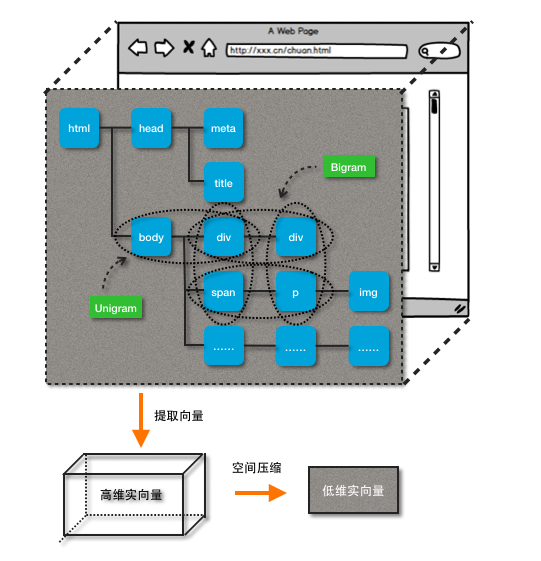

> 说明：可以想象将所有相关的网页提取出tag和div之类的属性构成一个词袋，然后使用one-gram和two-gram来表征不同的webshell的网页结构。

直接计算高维向量一方面不同网页结构大小各有不同，形成的向量会变得很稀疏，另一方向，过高的维度也会带来「维数灾难」，所以我们还需要做一个降维处理。但在该场景下，每必要用太复杂的降维或projection手法，直接对M取模，将N维向量压缩到M维即可。

构造好低维实向量，接下来就该定义相似度计算了。直观上，欧式距离和余弦距离是最容易的两种计算向量相似的距离。但是对长网页欧式明显不公平，而余弦只关注向量夹角的差异性不关注绝对长度上的差异（只关注方向性），也就是只关注tag之间的比例而非绝对数值，优惠存在对长网页过分抑制。所以综合考虑，我们简介杰拉德相似的思想，定义伪距离如下，表达的物理意义为两个网页相同部分与不同部分的比值。

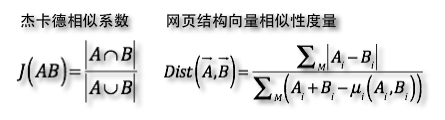

有了向量和相似性计算，我们就不得不面临一个工程问题，这种笛卡尔积式的两两比较，在大规模环境中应用就是灾难。回想一下生物指纹识别领域中的待识别指纹同指纹库中的指纹匹配的过程：1. 先比对指纹的模式区、核心区等大的总体特征；2. 满足总体特征的，再比对特征点等局部特征。借鉴词思想，我们可以对离散的样本数据构造一个网格计算。

在向量空间中定义一套超立方网格，把空间切割成多个超网格，以超网格中心坐标来表示其自身。对于待检测样本，先计算器会落到哪个超网格，然后再同该超网格中的训练样本进行一一比对，最终找到最相似的样本。但是需要注意的是，一套网格会出现「区域隔离」的问题，可通过构造不同的多套网格来避免。

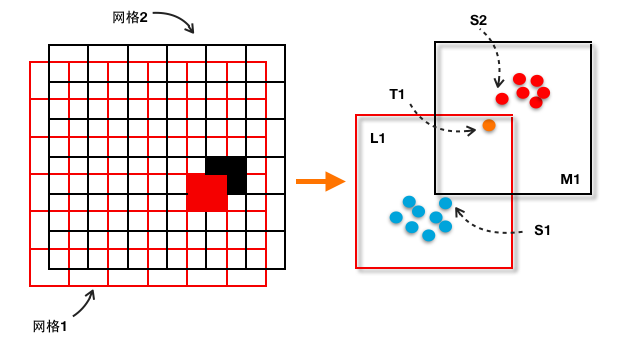

如图T1是待检测网页的特征向量，在红色网格中，命中了超网格L1，进而找到在宏伟网格中最相似的样本维S1。而在黑色网格中，同样的方法找到了样本S2。最终再来比较与S1、S2的伪距离，得到最相似样本S2。（也就是通过网格搜索方式减小比对空间）

#### 2.4.2 一句话webshell识别

对于一句话webshell，response层面数据不需要做太复杂的模型，简单的特征匹配就组都。或者也可以使用2.2中二步样子的方法来验证。如，联合主机agent做代码层面的关联，或者关联命令日志异常，又或者关联2.3中的getshell nday等。